In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread, imread_collection, imshow, imshow_collection
from skimage.filters import threshold_otsu
from skimage.transform import resize, rotate, resize
from skimage.color import rgb2gray
from skimage import transform

from scipy.signal import convolve2d
from scipy.fft import fft2, fftshift

from PIL import Image
import os
import imagehash

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine

import seaborn as sns
from keras.preprocessing import image

# Working with Images Lab
## Information retrieval, preprocessing, and feature extraction

In this lab, you'll work with images of felines (cats), which have been classified according to their taxonomy. Each subfolder contains images of a particular species. The dataset is located [here](https://www.kaggle.com/datasets/datahmifitb/felis-taxonomy-image-classification) but it's also provided to you in the `data/` folder.

### Problem 1. Some exploration (1 point)
How many types of cats are there? How many images do we have of each? What is a typical image size? Are there any outliers in size?

In [3]:
all_cats = imread_collection("data/*")

In [5]:
# How many types of cats are there (the number of folders which represent different type of cats)

len(all_cats)

7

In [7]:
african_wildcats = imread_collection("data/african-wildcat/*")

In [9]:
blackfoot_cats = imread_collection("data/blackfoot-cat/*")

In [11]:
chinese_mountain_cats = imread_collection("data/chinese-mountain-cat/*")

In [1300]:
domestic_cats = imread_collection("data/domestic-cat/*")

In [1302]:
european_wildcats = imread_collection("data/european-wildcat/*")

In [1304]:
jungle_cats = imread_collection("data/jungle-cat/*")

In [1305]:
sand_cats = imread_collection("data/sand-cat/*")

In [1308]:
# how many images for each kind

len(african_wildcats)

91

In [1310]:
len(blackfoot_cats)

79

In [1312]:
len(chinese_mountain_cats)

42

In [1314]:
len(domestic_cats)

64

In [1316]:
len(european_wildcats)

85

In [1318]:
len(jungle_cats)

86

In [1320]:
len(sand_cats)

72

In [1322]:
list(african_wildcats)

[array([[[153, 119,  81],
         [153, 119,  81],
         [153, 119,  81],
         ...,
         [128, 107,  64],
         [128, 107,  64],
         [129, 108,  65]],
 
        [[153, 119,  81],
         [153, 119,  81],
         [153, 119,  81],
         ...,
         [128, 107,  64],
         [128, 107,  64],
         [129, 108,  65]],
 
        [[153, 119,  81],
         [153, 119,  81],
         [153, 119,  81],
         ...,
         [129, 108,  65],
         [128, 107,  64],
         [129, 108,  65]],
 
        ...,
 
        [[116, 116, 116],
         [250, 250, 250],
         [252, 252, 252],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[116, 116, 116],
         [250, 250, 250],
         [252, 252, 252],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[116, 116, 116],
         [250, 250, 250],
         [252, 252, 252],
         ...,
         [255, 255, 255],
  

In [1324]:
african_wildcats[0].size

151050

In [151]:
dimensions = {"width": [], "height": []}

for image in african_wildcats:
    height, width = image.shape[:2]
    dimensions["width"].append(width)
    dimensions["height"].append(height)
    
cat_dimensions = pd.DataFrame(dimensions)

In [153]:
# statistics of image sizes

cat_dimensions.describe()

width      height
count   87.000000   87.000000
mean   255.528736  196.919540
std     34.819414   31.986632
min    150.000000  124.000000
25%    230.000000  183.000000
50%    272.000000  184.000000
75%    275.000000  200.500000
max    327.000000  275.000000

In [26]:
# The average value is:
# 
# mean	255.868132	196.692308

# Outliers:
# 
# std	34.199808	31.365831

In [155]:
cat_dimensions.isnull().sum()

width     0
height    0
dtype: int64

### Problem 2. Duplicat(e)s (1 point)
Find a way to filter out (remove) identical images. I would recommnend using file hashes, but there are many approaches. Keep in mind that during file saving, recompression, etc., a lot of artifacts can change the file content (bytes), but not visually.

In [13]:
african_cat_files = african_wildcats.files

In [15]:
african_cat_data = pd.DataFrame(african_cat_files, columns=["african_cat_file"])

In [17]:
def calculate_hash(african_cat_file):
    try:
        with Image.open(african_cat_file) as img:
            return str(imagehash.phash(img))
    except Exception as e:
        print(f"Error processing {african_cat_file}: {e}")
        return None

In [19]:
african_cat_data["image_hash"] = african_cat_data["african_cat_file"].apply(calculate_hash)

In [21]:
duplicates = african_cat_data[african_cat_data.duplicated("image_hash", keep=False)]

In [23]:
duplicates

african_cat_file        image_hash
10  data/african-wildcat/af (11).jpg  cba4349b0cca75ab
15  data/african-wildcat/af (16).jpg  86421f393cc1c1ff
26  data/african-wildcat/af (27).jpg  9133eeece0763318
31  data/african-wildcat/af (32).jpg  9133eeece0763318
36  data/african-wildcat/af (37).jpg  cba4349b0cca75ab
49  data/african-wildcat/af (50).jpg  a9d4960be960cb9e
60  data/african-wildcat/af (61).jpg  a9d4960be960cb9e
73  data/african-wildcat/af (74).jpg  86421f393cc1c1ff

In [25]:
african_cat_unique = african_cat_data.drop_duplicates("image_hash", keep="first")

In [27]:
african_cat_unique

african_cat_file        image_hash
0    data/african-wildcat/af (1).jpg  cbecb45b8c4af209
1    data/african-wildcat/af (2).jpg  d0387867e7e0c617
2    data/african-wildcat/af (3).jpg  ca310c273e3d39cd
3    data/african-wildcat/af (4).jpg  edae06d358cd48e8
4    data/african-wildcat/af (5).jpg  963367285acf2d31
..                               ...               ...
86  data/african-wildcat/af (87).jpg  cc3b66599224dbc6
87  data/african-wildcat/af (88).jpg  e11cb848bb7322bb
88  data/african-wildcat/af (89).jpg  9425686ade5ad95a
89  data/african-wildcat/af (90).jpg  cb2394c88b4b796b
90  data/african-wildcat/af (91).jpg  86da595c1e4e1a3d

[87 rows x 2 columns]

In [29]:
for _, row in duplicates.iterrows():
    if row["african_cat_file"] not in african_cat_unique["african_cat_file"].values:
        os.remove(row["african_cat_file"])
        print(f"Removed duplicate cat image: {row['african_cat_file']}")

Removed duplicate cat image: data/african-wildcat/af (32).jpg
Removed duplicate cat image: data/african-wildcat/af (37).jpg
Removed duplicate cat image: data/african-wildcat/af (61).jpg
Removed duplicate cat image: data/african-wildcat/af (74).jpg


In [31]:
african_cat_unique

african_cat_file        image_hash
0    data/african-wildcat/af (1).jpg  cbecb45b8c4af209
1    data/african-wildcat/af (2).jpg  d0387867e7e0c617
2    data/african-wildcat/af (3).jpg  ca310c273e3d39cd
3    data/african-wildcat/af (4).jpg  edae06d358cd48e8
4    data/african-wildcat/af (5).jpg  963367285acf2d31
..                               ...               ...
86  data/african-wildcat/af (87).jpg  cc3b66599224dbc6
87  data/african-wildcat/af (88).jpg  e11cb848bb7322bb
88  data/african-wildcat/af (89).jpg  9425686ade5ad95a
89  data/african-wildcat/af (90).jpg  cb2394c88b4b796b
90  data/african-wildcat/af (91).jpg  86da595c1e4e1a3d

[87 rows x 2 columns]

### Problem 3. Loading a model (2 points)
Find a suitable, trained convolutional neural network classifier. I recommend `ResNet50` as it's small enough to run well on any machine and powerful enough to make reasonable predictions. Most ready-made classifiers have been trained for 1000 classes.

You'll need to install libraries and possibly tinker with configurations for this task. When you're done, display the total number of layers and the total number of parameters. For ResNet50, you should expect around 50 layers and 25M parameters.

In [33]:
model = ResNet50()

In [35]:
model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [37]:
#  Total params: 25,636,712 (97.80 MB)
#  Trainable params: 25,583,592 (97.59 MB)
#  Non-trainable params: 53,120 (207.50 KB)

model.count_params()

25636712

In [201]:
len(model.layers)

177

### Problem 4. Prepare the images (1 point)
You'll need to prepare the images for passing to the model. To do so, they have to be resized to the same dimensions. Most available models have a specific requirement for sizes. You may need to do additional preprocessing, depending on the model requirements. These requirements should be easily available in the model documentation.

In [39]:
def preprocess_image(img):
    img_resized = resize(img, (224, 224), anti_aliasing=True)
    img_resized = (img_resized * 255).astype(np.uint8) 
    img_array = np.expand_dims(img_resized, axis=0) 
    img_array = preprocess_input(img_array) 
    return img_array

In [41]:
preprocessed_images = [preprocess_image(image) for image in blackfoot_cats]

In [43]:
preprocessed_images

[array([[[[ -93.939,  -96.779,  -96.68 ],
          [ -95.939,  -98.779,  -98.68 ],
          [ -98.939, -101.779, -101.68 ],
          ...,
          [ -79.939,  -58.779,  -66.68 ],
          [ -70.939,  -51.779,  -58.68 ],
          [ -66.939,  -49.779,  -55.68 ]],
 
         [[ -96.939,  -99.779,  -99.68 ],
          [ -98.939, -100.779, -100.68 ],
          [ -99.939, -102.779, -102.68 ],
          ...,
          [ -85.939,  -66.779,  -77.68 ],
          [ -87.939,  -69.779,  -78.68 ],
          [ -90.939,  -73.779,  -79.68 ]],
 
         [[-100.939, -102.779, -101.68 ],
          [-100.939, -102.779, -101.68 ],
          [-100.939, -102.779, -101.68 ],
          ...,
          [ -91.939,  -73.779,  -87.68 ],
          [-101.939,  -83.779,  -96.68 ],
          [-103.939,  -85.779,  -94.68 ]],
 
         ...,
 
         [[-102.939, -115.779, -122.68 ],
          [-102.939, -115.779, -122.68 ],
          [-102.939, -115.779, -122.68 ],
          ...,
          [-102.939, -115.779, -1

### Problem 5. Load the images efficiently (1 point)
Now that you've seen how to prepare the images for passing to the model... find a way to do it efficiently. Instead of loading the entire dataset in the RAM, read the images in batches (e.g. 4 images at a time). The goal is to read these, preprocess them, maybe save the preprocessed results in RAM.

If you've already done this in one of the previous problems, just skip this one. You'll get your point for it.

\* Even better, save the preprocessed image arrays (they will not be valid .jpg file) as separate files, so you can load them "lazily" in the following steps. This is a very common optimization to work with large datasets.

In [45]:
blackfoot_cat_files = blackfoot_cats.files

In [47]:
preprocessed_dir = "data/blackfoot_cats_preprocessed"
os.makedirs(preprocessed_dir, exist_ok=True)

batch_size = 4

# Iterating preprocessed images in batches

for i in range(0, len(blackfoot_cat_files), batch_size):
    batch_paths = blackfoot_cat_files[i:i + batch_size]
    batch_images = []

    for image_path in batch_paths:
        img = imread(image_path)
        preprocessed_img = preprocess_image(img)
        batch_images.append(preprocessed_img)

    batch_images = np.vstack(batch_images)

    predictions = model.predict(batch_images)
    
    # Save preprocessed images
    
    save_path = os.path.join(preprocessed_dir, f"img_{i}.npy")
    np.save(save_path, preprocessed_img)
    print(f"Saved preprocessed image to {save_path}")

    decoded_predictions = decode_predictions(predictions, top=3)
    for j, prediction in enumerate(decoded_predictions):
        print(f"Predictions for image {batch_paths[j]}:")
        for _, label, prob in prediction:
            print(f"  {label}: {prob:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
Saved preprocessed image to data/blackfoot_cats_preprocessed/img_0.npy
Predictions for image data/blackfoot-cat/bc (1).jpg:
  Egyptian_cat: 0.40
  tiger_cat: 0.15
  jaguar: 0.13
Predictions for image data/blackfoot-cat/bc (2).jpg:
  tiger_cat: 0.38
  Egyptian_cat: 0.27
  tiger: 0.15
Predictions for image data/blackfoot-cat/bc (3).jpg:
  leopard: 0.46
  cheetah: 0.24
  snow_leopard: 0.16
Predictions for image data/blackfoot-cat/bc (4).jpg:
  hyena: 0.32
  cheetah: 0.23
  tabby: 0.09
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Saved preprocessed image to data/blackfoot_cats_preprocessed/img_4.npy
Predictions for image data/blackfoot-cat/bc (5).jpg:
  tiger: 0.35
  tiger_cat: 0.30
  Egyptian_cat: 0.13
Predictions for image data/blackfoot-cat/bc (6).jpg:
  tabby: 0.33
  tiger_cat: 0.28
  Egyptian_cat: 0.17
Predictions for image data/blackfoot-cat/bc (7).jpg:
  hyena: 0.78
  cheetah: 0.16
  African_hunting_dog: 0.04
Predictions for image data/blackfoot-cat/

### Problem 6. Predictions (1 point)
Finally, you're ready to get into the meat of the problem. Obtain predictions from your model and evaluate them. This will likely involve manual work to decide how the returned classes relate to the original ones.

Create a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) to evaluate the classification.

In [49]:
preprocessed_files = [os.path.join("data/blackfoot_cats_preprocessed", f) for f in os.listdir("data/blackfoot_cats_preprocessed") if f.endswith(".npy")]

In [51]:
preprocessed_files

['data/blackfoot_cats_preprocessed/img_52.npy',
 'data/blackfoot_cats_preprocessed/img_44.npy',
 'data/blackfoot_cats_preprocessed/img_68.npy',
 'data/blackfoot_cats_preprocessed/img_40.npy',
 'data/blackfoot_cats_preprocessed/img_56.npy',
 'data/blackfoot_cats_preprocessed/img_24.npy',
 'data/blackfoot_cats_preprocessed/img_8.npy',
 'data/blackfoot_cats_preprocessed/img_32.npy',
 'data/blackfoot_cats_preprocessed/img_36.npy',
 'data/blackfoot_cats_preprocessed/img_20.npy',
 'data/blackfoot_cats_preprocessed/img_0.npy',
 'data/blackfoot_cats_preprocessed/img_12.npy',
 'data/blackfoot_cats_preprocessed/img_16.npy',
 'data/blackfoot_cats_preprocessed/img_28.npy',
 'data/blackfoot_cats_preprocessed/img_4.npy',
 'data/blackfoot_cats_preprocessed/img_72.npy',
 'data/blackfoot_cats_preprocessed/img_64.npy',
 'data/blackfoot_cats_preprocessed/img_60.npy',
 'data/blackfoot_cats_preprocessed/img_48.npy',
 'data/blackfoot_cats_preprocessed/img_76.npy']

In [53]:
all_predictions = []
predictions = model.predict(batch_images)

# Top 1 prediction for image and class label

decoded_predictions = decode_predictions(predictions, top=1)  
batch_predictions = [pred[0][0] for pred in decoded_predictions]
all_predictions.extend(batch_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


In [55]:
all_predictions

['n02127052', 'n02128385', 'n02127052']

In [57]:
np.save("data/blackfoot_cats_preprocessed/predictions.npy", all_predictions)

In [59]:
decoded_predictions

[[('n02127052', 'lynx', 0.3646431)],
 [('n02128385', 'leopard', 0.16397262)],
 [('n02127052', 'lynx', 0.5393637)]]

In [61]:
true_labels = ["tiger_cat", "lynx"] 

imagenet_to_original_class = {
    'n02123159': "tiger_cat",
    'n02127052': "lynx"
}

def map_imagenet_label_to_original_class(imagenet_label):
    return imagenet_to_original_class.get(imagenet_label, "unknown")

mapped_predictions = [map_imagenet_label_to_original_class(pred) for pred in all_predictions]

In [63]:
len_true_labels = len(true_labels)
len_all_predictions = len(all_predictions)

print(f"Number of true labels: {len_true_labels}")
print(f"Number of predictions: {len_all_predictions}")

Number of true labels: 2
Number of predictions: 3


In [65]:
all_predictions

['n02127052', 'n02128385', 'n02127052']

In [67]:
# Check and remove inconsistent data

if len_true_labels != len_all_predictions:
    print("Mismatch found. Removing inconsistent data.")
    
    min_len = min(len_true_labels, len_all_predictions)

    true_labels = true_labels[:min_len]
    all_predictions = all_predictions[:min_len]
    
    print("After removal:")
    print(f"Number of true labels: {len(true_labels)}")
    print(f"Number of predictions: {len(all_predictions)}")

Mismatch found. Removing inconsistent data.
After removal:
Number of true labels: 2
Number of predictions: 2


In [71]:
true_labels

['tiger_cat', 'lynx']

In [73]:
all_predictions

['n02127052', 'n02128385']

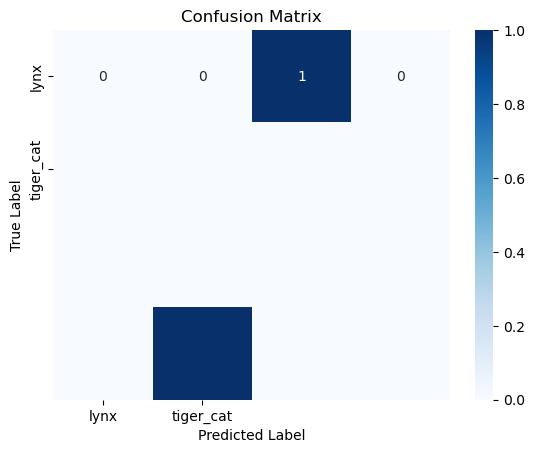

In [75]:
conf_matrix = confusion_matrix(true_labels, all_predictions)

class_names = np.unique(true_labels)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Problem 7. Grayscale (1 point)
Converting the images to grayscale should affect the classification negatively, as we lose some of the color information.

Find a way to preprocess the images to grayscale (using what you already have in Problem 4 and 5), pass them to the model, and compare the classification results to the previous ones.

In [77]:
preprocessed_dir_gray = "data/chinese_mountain_cats_gray"
os.makedirs(preprocessed_dir_gray, exist_ok=True)

In [79]:
gray_labels = [os.path.basename(os.path.dirname(preprocessed_dir_gray)) for file_path in chinese_mountain_cats.files]

In [81]:
# Preprocess and save images in grayscale
for idx, img in enumerate(chinese_mountain_cats):
    img_gray = rgb2gray(img)  # Convert to grayscale
    img_gray_resized = np.array(img_gray).astype("float32")/255
    img_gray_resized = transform.resize(img_gray_resized, (224, 224))  # Resize to 224x224
    img_gray_resized = np.expand_dims(img_gray_resized, axis=-1)  # Expand dimensions to (224, 224, 1)
    img_gray_resized = np.repeat(img_gray_resized, 3, axis=-1)  # Repeat single channel to create 3 channels
    img_preprocessed = preprocess_input(img_gray_resized)
    save_path_gray = os.path.join(preprocessed_dir_gray, f"img_{idx}.npy")
    np.save(save_path_gray, img_preprocessed)
    print(f"Saved preprocessed grayscale image to {save_path_gray}")

Saved preprocessed grayscale image to data/chinese_mountain_cats_gray/img_0.npy
Saved preprocessed grayscale image to data/chinese_mountain_cats_gray/img_1.npy
Saved preprocessed grayscale image to data/chinese_mountain_cats_gray/img_2.npy
Saved preprocessed grayscale image to data/chinese_mountain_cats_gray/img_3.npy
Saved preprocessed grayscale image to data/chinese_mountain_cats_gray/img_4.npy
Saved preprocessed grayscale image to data/chinese_mountain_cats_gray/img_5.npy
Saved preprocessed grayscale image to data/chinese_mountain_cats_gray/img_6.npy
Saved preprocessed grayscale image to data/chinese_mountain_cats_gray/img_7.npy
Saved preprocessed grayscale image to data/chinese_mountain_cats_gray/img_8.npy
Saved preprocessed grayscale image to data/chinese_mountain_cats_gray/img_9.npy
Saved preprocessed grayscale image to data/chinese_mountain_cats_gray/img_10.npy
Saved preprocessed grayscale image to data/chinese_mountain_cats_gray/img_11.npy
Saved preprocessed grayscale image to 

In [83]:
preprocessed_files_gray = [os.path.join(preprocessed_dir_gray, f) for f in os.listdir(preprocessed_dir_gray) if f.endswith(".npy")]

In [85]:
batch_size_gray = 4

chinese_cat_gray_predictions = []

# Iterate preprocessed images in batches

for i in range(0, len(preprocessed_files_gray), batch_size):
    gray_batch_files = preprocessed_files_gray[i:i + batch_size]
    gray_batch_images = []
        
        
    # Load each preprocessed image file in the batch
    for file_path in gray_batch_files:
        preprocessed_img_gray = np.load(file_path)
        gray_batch_images.append(preprocessed_img_gray)
        
    gray_batch_images = np.array(gray_batch_images)

    # Make predictions on the preprocessed images
    predictions_gray = model.predict(gray_batch_images)

    # Decode predictions
    decoded_predictions_gray = decode_predictions(predictions, top=1)  # Get top-1 prediction for each image
    batch_predictions_gray = [pred[0][0] for pred in decoded_predictions]  # Top-1 ImageNet class label (e.g., 'n02124075')
    chinese_cat_gray_predictions.extend(batch_predictions)

# Save predictions
np.save("data/chinese_mountain_cats_gray/all_predictions_gray.npy", chinese_cat_gray_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


In [87]:
chinese_cat_gray_predictions

['n02127052',
 'n02128385',
 'n02127052',
 'n02127052',
 'n02128385',
 'n02127052',
 'n02127052',
 'n02128385',
 'n02127052',
 'n02127052',
 'n02128385',
 'n02127052',
 'n02127052',
 'n02128385',
 'n02127052',
 'n02127052',
 'n02128385',
 'n02127052',
 'n02127052',
 'n02128385',
 'n02127052',
 'n02127052',
 'n02128385',
 'n02127052',
 'n02127052',
 'n02128385',
 'n02127052',
 'n02127052',
 'n02128385',
 'n02127052',
 'n02127052',
 'n02128385',
 'n02127052']

In [89]:
len_gray_labels = len(gray_labels)
len_gray_predictions = len(chinese_cat_gray_predictions)

print(f"Number of gray labels: {len_gray_labels}")
print(f"Number of gray predictions: {len_gray_predictions}")

Number of gray labels: 42
Number of gray predictions: 33


In [91]:
# Check and remove inconsistent data

if len_gray_labels != len_gray_predictions:
    print("Mismatch found. Removing inconsistent data.")
    
    min_len = min(len_gray_labels, len_gray_predictions)

    gray_labels = gray_labels[:min_len]
    chinese_cat_gray_predictions = chinese_cat_gray_predictions[:min_len]
    
    print("After removal:")
    print(f"Number of true labels: {len(gray_labels)}")
    print(f"Number of predictions: {len(chinese_cat_gray_predictions)}")

Mismatch found. Removing inconsistent data.
After removal:
Number of true labels: 33
Number of predictions: 33


In [93]:
# Ensure the lengths match
assert len(gray_labels) == len(chinese_cat_gray_predictions), f"Mismatch between number of true labels ({len(gray_labels)}) and grayscale predictions ({len(chinese_cat_gray_predictions)})"

# Mapping dictionary: ImageNet label to original class label
image_to_original_class = {
    'n02127052': "lynx, catamount",
    'n02128385': "leopard"
}

# Mapping function
def map_label_to_original_class(image_label):
    return imagenet_to_original_class.get(image_label, "unknown")  # Default to 'unknown' if not found

# Apply mapping function to all predictions
mapped_predictions_gray = [map_label_to_original_class(pred) for pred in chinese_cat_gray_predictions]

In [95]:
mapped_predictions_gray

['lynx',
 'unknown',
 'lynx',
 'lynx',
 'unknown',
 'lynx',
 'lynx',
 'unknown',
 'lynx',
 'lynx',
 'unknown',
 'lynx',
 'lynx',
 'unknown',
 'lynx',
 'lynx',
 'unknown',
 'lynx',
 'lynx',
 'unknown',
 'lynx',
 'lynx',
 'unknown',
 'lynx',
 'lynx',
 'unknown',
 'lynx',
 'lynx',
 'unknown',
 'lynx',
 'lynx',
 'unknown',
 'lynx']

### Problem 8. Deep image features (1 point)
Find a way to extract one-dimensional vectors (features) for each (non-grayscale) image, using your model. This is typically done by "short-circuiting" the model output to be an intermediate layer, while keeping the input the same. 

In case the outputs (also called feature maps) have different shapes, you can flatten them in different ways. Try to not create huge vectors; the goal is to have a relatively short sequence of numbers which describes each image.

You may find a tutorial like [this](https://towardsdatascience.com/exploring-feature-extraction-with-cnns-345125cefc9a) pretty useful but note your implementation will depend on what model (and framework) you've decided to use.

It's a good idea to save these as one or more files, so you'll spare yourself a ton of preprocessing.

In [97]:
Model

keras.src.models.model.Model

In [99]:
base_model = ResNet50(weights = "imagenet", include_top = True)

In [101]:
modified_model = Model(inputs = base_model.input, outputs = base_model.get_layer("avg_pool").output)

In [103]:
modified_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [105]:
# Load feature vector
feature_vector = np.load("data/blackfoot_cats_preprocessed/predictions.npy")

In [107]:
feature_vector.shape

(3,)

### Problem 9. Putting deep image features to use (1 points)
Try to find similar images, using a similarity metric on the features you got in the previous problem. Two good metrics are `mean squared error` and `cosine similarity`. How do they work? Can you spot images that look too similar? Can you explain why?

\* If we were to take Fourier features (in a similar manner, these should be a vector of about the same length), how do they compare to the deep features; i.e., which features are better to "catch" similar images?

In [273]:
feature_files = [os.path.join(preprocessed_dir, f) for f in os.listdir(preprocessed_dir) if f.endswith(".npy")]
features = [np.load(file) for file in feature_files]

In [275]:
feature_files

['data/blackfoot_cats_preprocessed/predictions.npy',
 'data/blackfoot_cats_preprocessed/img_52.npy',
 'data/blackfoot_cats_preprocessed/img_44.npy',
 'data/blackfoot_cats_preprocessed/img_68.npy',
 'data/blackfoot_cats_preprocessed/img_40.npy',
 'data/blackfoot_cats_preprocessed/img_56.npy',
 'data/blackfoot_cats_preprocessed/img_24.npy',
 'data/blackfoot_cats_preprocessed/img_8.npy',
 'data/blackfoot_cats_preprocessed/img_32.npy',
 'data/blackfoot_cats_preprocessed/img_36.npy',
 'data/blackfoot_cats_preprocessed/img_20.npy',
 'data/blackfoot_cats_preprocessed/img_0.npy',
 'data/blackfoot_cats_preprocessed/img_12.npy',
 'data/blackfoot_cats_preprocessed/img_16.npy',
 'data/blackfoot_cats_preprocessed/img_28.npy',
 'data/blackfoot_cats_preprocessed/img_4.npy',
 'data/blackfoot_cats_preprocessed/img_72.npy',
 'data/blackfoot_cats_preprocessed/img_64.npy',
 'data/blackfoot_cats_preprocessed/img_60.npy',
 'data/blackfoot_cats_preprocessed/img_48.npy',
 'data/blackfoot_cats_preprocessed/img

In [277]:
features

[array(['n02127052', 'n02128385', 'n02127052'], dtype='<U9'),
 array([[[[  43.060997 ,   43.221    ,   36.32     ],
          [  41.060997 ,   42.221    ,   34.32     ],
          [ -18.939003 ,  -15.778999 ,  -23.68     ],
          ...,
          [ -67.939    ,  -89.779    , -100.68     ],
          [ -23.939003 ,  -44.779    ,  -58.68     ],
          [ -13.939003 ,  -34.779    ,  -48.68     ]],
 
         [[  24.060997 ,   23.221    ,   16.32     ],
          [  37.060997 ,   38.221    ,   30.32     ],
          [ -18.939003 ,  -15.778999 ,  -23.68     ],
          ...,
          [ -51.939003 ,  -73.779    ,  -84.68     ],
          [  -9.939003 ,  -30.779    ,  -44.68     ],
          [  -3.939003 ,  -24.779    ,  -38.68     ]],
 
         [[  30.060997 ,   29.221    ,   22.32     ],
          [  48.060997 ,   49.221    ,   41.32     ],
          [   4.060997 ,    6.2210007,   -1.6800003],
          ...,
          [ -30.939003 ,  -52.779    ,  -63.68     ],
          [   8.060997 

In [279]:
# Check feature vectors for the same shape

feature_shapes = [feature.shape for feature in features]
unique_shapes = set(feature_shapes)

In [281]:
feature_shapes

[(3,),
 (1, 224, 224, 3),
 (1, 224, 224, 3),
 (1, 224, 224, 3),
 (1, 224, 224, 3),
 (1, 224, 224, 3),
 (1, 224, 224, 3),
 (1, 224, 224, 3),
 (1, 224, 224, 3),
 (1, 224, 224, 3),
 (1, 224, 224, 3),
 (1, 224, 224, 3),
 (1, 224, 224, 3),
 (1, 224, 224, 3),
 (1, 224, 224, 3),
 (1, 224, 224, 3),
 (1, 224, 224, 3),
 (1, 224, 224, 3),
 (1, 224, 224, 3),
 (1, 224, 224, 3),
 (1, 224, 224, 3)]

In [283]:
unique_shapes

{(1, 224, 224, 3), (3,)}

In [285]:
if len(unique_shapes) != 1:
    print(f"Inconsistent feature shapes found: {unique_shapes}")
    # Filter inconsistent shapes
    consistent_shape = max(unique_shapes, key=lambda shape: feature_shapes.count(shape))
    features = [fv for fv in features if fv.shape == consistent_shape]
    print(f"Filtered to consistent shape: {consistent_shape}")

Inconsistent feature shapes found: {(1, 224, 224, 3), (3,)}
Filtered to consistent shape: (1, 224, 224, 3)


In [287]:
# Resize to 224x224

for idx, img in enumerate(chinese_mountain_cats):
    img_preprocessed_resized = np.array(img_gray).astype("float32")/255
    img_preprocessed_resized = transform.resize(img_preprocessed_resized, (224, 224)) 

In [289]:
features = img_preprocessed_resized

In [291]:
features

array([[7.1160635e-04, 6.5684260e-04, 5.7914801e-04, ..., 4.1611744e-05,
        5.0365245e-05, 5.0365245e-05],
       [7.1049650e-04, 6.4709364e-04, 5.6384993e-04, ..., 4.1611744e-05,
        5.0365245e-05, 5.0365245e-05],
       [6.9428229e-04, 6.3452980e-04, 5.4888276e-04, ..., 4.1611744e-05,
        5.0365245e-05, 5.0365245e-05],
       ...,
       [8.9112704e-04, 9.4951055e-04, 1.1289658e-03, ..., 2.2925282e-04,
        1.6086554e-04, 1.2711009e-04],
       [7.7128847e-04, 1.0338504e-03, 1.1900725e-03, ..., 2.3714891e-04,
        1.7916216e-04, 1.2488998e-04],
       [7.0550450e-04, 1.0730857e-03, 1.1930756e-03, ..., 2.4974861e-04,
        1.9557006e-04, 1.3463899e-04]], dtype=float32)

In [293]:
# Function to compute mean squared error

def compute_mse(vec1, vec2):
    return mean_squared_error(vec1, vec2)

# Function to compute cosine similarity

def compute_cosine_similarity(vec1, vec2):
    return 1 - cosine(vec1, vec2)

# Find pairs of images with high similarity

mse_threshold = 0.01  
cosine_threshold = 0.95

similar_pairs_mse = []
similar_pairs_cosine = []

for i in range(len(features)):
    for j in range(i + 1, len(features)):
        mse = compute_mse(features[i], features[j])
        cosine_sim = compute_cosine_similarity(features[i], features[j])
        
        if mse < mse_threshold:
            similar_pairs_mse.append((i, j, mse))
        if cosine_sim > cosine_threshold:
            similar_pairs_cosine.append((i, j, cosine_sim))

In [295]:
similar_pairs_mse

[(0, 1, 5.3571694e-09),
 (0, 2, 2.3781022e-08),
 (0, 3, 4.990005e-08),
 (0, 4, 7.566282e-08),
 (0, 5, 8.800932e-08),
 (0, 6, 8.7251024e-08),
 (0, 7, 9.497601e-08),
 (0, 8, 1.0216604e-07),
 (0, 9, 1.0213015e-07),
 (0, 10, 1.0922123e-07),
 (0, 11, 1.14860086e-07),
 (0, 12, 1.2031246e-07),
 (0, 13, 1.4441932e-07),
 (0, 14, 1.6769384e-07),
 (0, 15, 1.7240416e-07),
 (0, 16, 1.9341813e-07),
 (0, 17, 2.1282754e-07),
 (0, 18, 2.0066436e-07),
 (0, 19, 1.8005036e-07),
 (0, 20, 1.812389e-07),
 (0, 21, 1.8531568e-07),
 (0, 22, 2.0796607e-07),
 (0, 23, 2.3079238e-07),
 (0, 24, 2.3248127e-07),
 (0, 25, 2.3600805e-07),
 (0, 26, 2.7615258e-07),
 (0, 27, 3.210604e-07),
 (0, 28, 2.8109687e-07),
 (0, 29, 2.5466696e-07),
 (0, 30, 2.718581e-07),
 (0, 31, 3.2909256e-07),
 (0, 32, 3.6130942e-07),
 (0, 33, 3.3698532e-07),
 (0, 34, 2.9535846e-07),
 (0, 35, 2.8560547e-07),
 (0, 36, 2.8707433e-07),
 (0, 37, 2.8199105e-07),
 (0, 38, 2.6556964e-07),
 (0, 39, 2.5459894e-07),
 (0, 40, 2.7848438e-07),
 (0, 41, 3.1670

In [297]:
similar_pairs_cosine

[(0, 1, 0.9848336514470943),
 (1, 2, 0.9819609130243324),
 (2, 3, 0.9853363297630986),
 (2, 4, 0.9518379014736842),
 (3, 4, 0.9872288821608326),
 (3, 5, 0.957519368266472),
 (4, 5, 0.9861820396729885),
 (4, 6, 0.9543990206643608),
 (5, 6, 0.9842268773672957),
 (5, 7, 0.9571510717483694),
 (6, 7, 0.9901267942397113),
 (6, 8, 0.9707515677246408),
 (6, 9, 0.9527889526215194),
 (7, 8, 0.9929678536502627),
 (7, 9, 0.9767763271104579),
 (8, 9, 0.9926462624061755),
 (8, 10, 0.9508925870045636),
 (9, 10, 0.9762818568678618),
 (9, 11, 0.9545649010521677),
 (10, 11, 0.982840822541178),
 (11, 12, 0.9781799913691704),
 (12, 13, 0.9829608120469069),
 (13, 14, 0.985442807970854),
 (14, 15, 0.9819385714252069),
 (15, 16, 0.961396162392364),
 (16, 17, 0.9698650132045099),
 (17, 18, 0.9864557958763943),
 (17, 19, 0.9556537953336074),
 (18, 19, 0.9832010632647586),
 (19, 20, 0.977252104757082),
 (20, 21, 0.9787340117218439),
 (21, 22, 0.9810432633312313),
 (22, 23, 0.9848035305632437),
 (22, 24, 0.96638

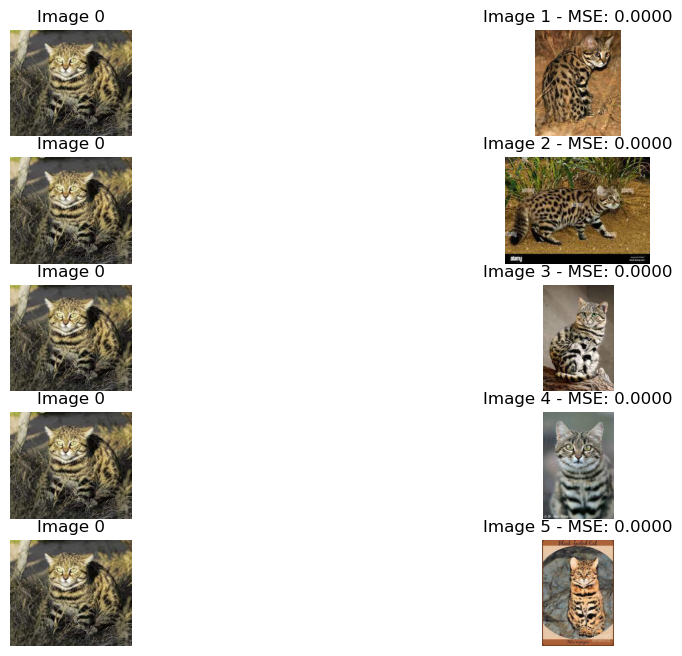

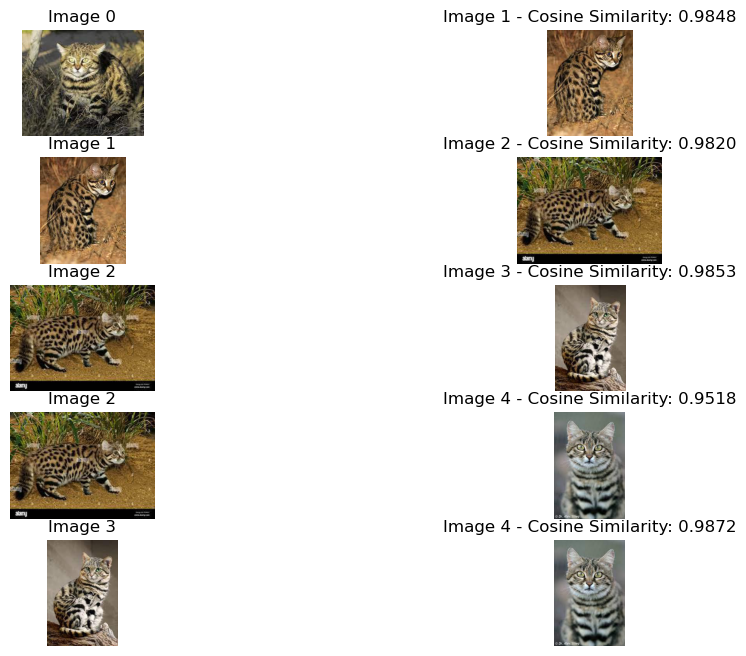

In [299]:
# Function to visualize similar images

def visualize_similar_images(image_files, similar_pairs, metric_name):
    plt.figure(figsize=(12, 8))
    for k, (i, j, score) in enumerate(similar_pairs[:5]): 
        img1 = imread(image_files[i])
        img2 = imread(image_files[j])
        plt.subplot(5, 2, 2*k + 1)
        plt.imshow(img1)
        plt.title(f"Image {i}")
        plt.axis("off")
        plt.subplot(5, 2, 2*k + 2)
        plt.imshow(img2)
        plt.title(f"Image {j} - {metric_name}: {score:.4f}")
        plt.axis("off")
    plt.show()

    
# Directory where original images are stored

image_dir = "data/blackfoot-cat/"

# Original images

original_images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpg")]

# Visualize similar images based on MSE

visualize_similar_images(original_images, similar_pairs_mse, "MSE")

# Visualize similar images based on Cosine Similarity

visualize_similar_images(original_images, similar_pairs_cosine, "Cosine Similarity")